In [28]:
import os, random, shutil, getpass, sys
import torch
import cv2
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd


In [29]:
!nvidia-smi
print("torch cuda available:", torch.cuda.is_available())

Tue Dec 16 06:07:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             29W /   70W |    3928MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [30]:
#run if local
# IN_COLAB = False

# import os, getpass

# required = ["README.md"]
# for f in required:
#     if not os.path.exists(f):
#         raise RuntimeError("Run this notebook from inside the repo folder (where README.md is).")

# #set local dataset folder
# DATA_ROOT = "/path/to/traffic_data"  # folder that contains train/val/test (or contains a subfolder that does)

# print("Local ready. CWD =", os.getcwd())
# print("DATA_ROOT =", DATA_ROOT)


In [31]:
#run if in colab

IN_COLAB = True

# GPU check
os.system("nvidia-smi")

#colab imports
from google.colab import drive, files

#mount Drive
drive.mount("/content/drive")

#upload kaggle.json
files.upload() #select kaggle.json

#install packages
os.system("pip -q install ultralytics opencv-python matplotlib kagglehub")

#put Kaggle creds where tools expect them
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.copy("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

#dataset in Drive
DATA_ROOT = "/content/drive/MyDrive/traffic_data"
os.makedirs(DATA_ROOT, exist_ok=True)

print("Colab mode ready. DATA_ROOT =", DATA_ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving kaggle.json to kaggle (1).json
Colab mode ready. DATA_ROOT = /content/drive/MyDrive/traffic_data


In [32]:
REPO_URL = "https://github.com/elizabethszent/Detecting-Road-Objects-for-Autonomous-Cars-in-Egypt.git"
REPO_DIR = "Detecting-Road-Objects-for-Autonomous-Cars-in-Egypt"

if not os.path.exists(REPO_DIR):
    os.system(f"git clone {REPO_URL}")

os.chdir(REPO_DIR)
os.system("ls")

0

In [33]:
%cd /content/Detecting-Road-Objects-for-Autonomous-Cars-in-Egypt
!mkdir -p notebooks
!cp "/content/drive/MyDrive/Colab Notebooks/AutonomousCarsinEgypt.ipynb" "notebooks/AutonomousCarsinEgypt.ipynb"
!ls -lah notebooks

/content/Detecting-Road-Objects-for-Autonomous-Cars-in-Egypt
total 460K
drwxr-xr-x 2 root root 4.0K Dec 16 03:52 .
drwxr-xr-x 5 root root 4.0K Dec 16 06:07 ..
-rw------- 1 root root 452K Dec 16 06:07 AutonomousCarsinEgypt.ipynb


In [34]:
os.system('git config user.name "elizabethszent"')
os.system('git config user.email "elizabethszentmiklossy@gmail.com"')

token = getpass.getpass("GitHub token (hidden): ")
os.system(f"git remote set-url origin https://{token}@github.com/elizabethszent/Detecting-Road-Objects-for-Autonomous-Cars-in-Egypt.git")

# write/update .gitignor
gitignore_text = """data/
runs/
kaggle.json
.ipynb_checkpoints/
__pycache__/
*.pyc
.env
.venv/
venv/
.DS_Store
"""
with open(".gitignore", "w") as f:
    f.write(gitignore_text)

# if kaggle.json was ever tracked, untrack it now
os.system("git rm --cached kaggle.json || true")

#add files
os.system("git add .")
os.system('git commit -m "update notebooks and config" || echo "Nothing to commit"')
os.system("git branch -M main")
os.system("git push -u origin main")


GitHub token (hidden): ··········


0

In [35]:
#colab-only

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
else:
    print("Not running in Colab.")

!pip -q install kagglehub ultralytics opencv-python matplotlib
import kagglehub

dataset_path = kagglehub.dataset_download("mohamedra9ab/object-detection-for-autonomous-cars-egypt")
print("Dataset cache path:", dataset_path)

print(os.path.isdir(os.path.join(dataset_path, "train", "train", "images")))
print(os.path.isdir(os.path.join(dataset_path, "train", "train", "labels")))
print(os.path.isdir(os.path.join(dataset_path, "test", "test", "images")))
print(os.path.isdir(os.path.join(dataset_path, "test", "test", "labels")))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using Colab cache for faster access to the 'object-detection-for-autonomous-cars-egypt' dataset.
Dataset cache path: /kaggle/input/object-detection-for-autonomous-cars-egypt
True
True
True
True


In [36]:
print("dataset_path =", dataset_path)
!find "{dataset_path}" -maxdepth 4 -type d -path "*/val/*/images" | head -n 50
!find "{dataset_path}" -maxdepth 4 -type d -path "*/val/*/labels" | head -n 50
!find "{dataset_path}" -maxdepth 4 -type d -path "*/valid/*/images" | head -n 50
!find "{dataset_path}" -maxdepth 4 -type d -path "*/valid/*/labels" | head -n 50

dataset_path = /kaggle/input/object-detection-for-autonomous-cars-egypt
/kaggle/input/object-detection-for-autonomous-cars-egypt/val/val/images
/kaggle/input/object-detection-for-autonomous-cars-egypt/val/val/labels


In [37]:
yaml_text = f"""path: {dataset_path}
train: train/train/images
val: val/val/images
test: test/test/images

names:
  0: car
  1: bus
  2: truck
  3: motor
  4: bike
  5: rider
  6: person
  7: tuktuk
  8: train
  9: traffic_sign
  10: traffic_light
  11: banners
"""
open("egypt_traffic.yaml","w").write(yaml_text)
print(open("egypt_traffic.yaml").read())


path: /kaggle/input/object-detection-for-autonomous-cars-egypt
train: train/train/images
val: val/val/images
test: test/test/images

names:
  0: car
  1: bus
  2: truck
  3: motor
  4: bike
  5: rider
  6: person
  7: tuktuk
  8: train
  9: traffic_sign
  10: traffic_light
  11: banners



In [38]:
print("train exists:", os.path.isdir(os.path.join(dataset_path, "train/train/images")))
print("val exists:",   os.path.isdir(os.path.join(dataset_path, "val/val/images")))
print("test exists:",  os.path.isdir(os.path.join(dataset_path, "test/test/images")))

train exists: True
val exists: True
test exists: True


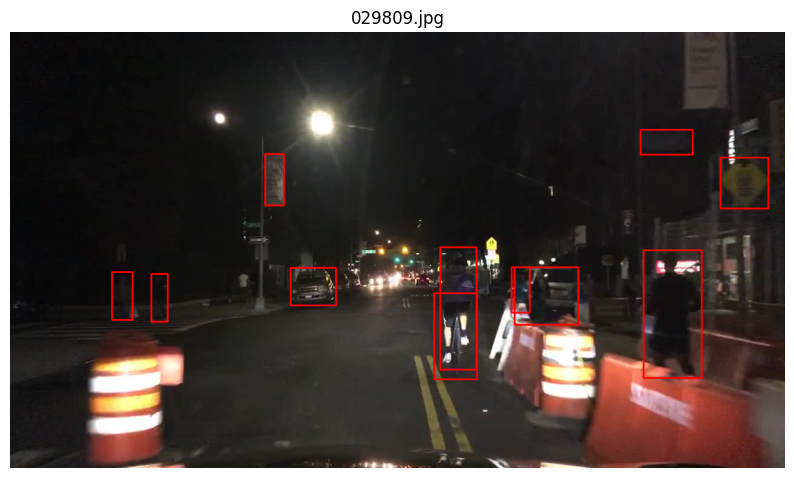

In [39]:
img_dir = os.path.join(dataset_path, "train/train/images")
lab_dir = os.path.join(dataset_path, "train/train/labels")

img_files = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".png",".jpeg"))]
img_name = random.choice(img_files)

img_path = os.path.join(img_dir, img_name)
lab_path = os.path.join(lab_dir, os.path.splitext(img_name)[0] + ".txt")

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

if os.path.exists(lab_path):
    with open(lab_path) as f:
        for line in f:
            c, xc, yc, bw, bh = map(float, line.split())
            x1 = int((xc - bw/2) * w); y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w); y2 = int((yc + bh/2) * h)
            cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)

plt.figure(figsize=(10,6))
plt.imshow(img); plt.title(img_name); plt.axis("off")
plt.show()


In [ ]:
IN_COLAB = "google.colab" in sys.modules

from ultralytics import YOLO

RUN_NAME = "yolov8s_baseline2"   # <-- set this ONCE
PROJECT_DIR = "/content/drive/MyDrive/yolo_runs" if IN_COLAB else "runs"

DEVICE = 0 if (IN_COLAB) else 0

model = YOLO("yolov8s.pt")

model.train(
    data="egypt_traffic.yaml",
    imgsz=640,
    epochs=50,
    batch=16,
    project=PROJECT_DIR,
    name=RUN_NAME,
    device=DEVICE,
    workers=8,
)



Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=egypt_traffic.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_baseline2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

In [ ]:
save_dir = "/content/drive/MyDrive/yolo_runs/yolov8s_baseline"  # same as in your train call
csv_path = os.path.join(save_dir, "results.csv")

df = pd.read_csv(csv_path)
last = df.iloc[-1]

print("\n=== FINAL VALIDATION METRICS ===")
print(f"Precision:  {last['metrics/precision(B)']:.4f}")
print(f"Recall:     {last['metrics/recall(B)']:.4f}")
print(f"mAP@0.5:    {last['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95: {last['metrics/mAP50-95(B)']:.4f}")

print("\n=== FINAL LOSSES (train vs val) ===")
print(f"Train box loss: {last['train/box_loss']:.4f} | Val box loss: {last['val/box_loss']:.4f}")
print(f"Train cls loss: {last['train/cls_loss']:.4f} | Val cls loss: {last['val/cls_loss']:.4f}")
print(f"Train dfl loss: {last['train/dfl_loss']:.4f} | Val dfl loss: {last['val/dfl_loss']:.4f}")